In [1]:
## Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import collections
from datetime import datetime

import folium
from folium.map import *
from folium import plugins
from folium.plugins import MeasureControl
from folium.plugins import FloatImage
from folium.plugins import MarkerCluster

import statsmodels.api as sm
import sklearn
import sklearn.model_selection


In [2]:
## Normalize columns of pd.DataFrame
def norm_df(dfx):
    dft1 = pd.DataFrame()
    for i in dfx.iteritems():
        norm = (i[1] - np.min(i[1]))/(np.max(i[1]) - np.min(i[1]))
        dft1 = pd.concat([dft1, norm], axis=1)
    return dft1


In [3]:
## outliers_thefts
def outliers_thefts(dfx, th):
    from scipy import stats
    import numpy as np

    z = np.abs(stats.zscore(dfx[th]))
    ix1 = (z <= 1)
    return ix1
    

In [ ]:
## DO NOT RUN! - start. Creatation of network
'''
dbXY = pd.read_csv(".//input//CTA_BusStops.csv", sep=",")
dbXY = dbXY.dropna()
dbXY.reset_index(inplace = True) 

G=nx.Graph()
try:
    for index1, row1 in dbXY.iterrows():
        print(str(index1) + ' - ' + str(len(dbXY.POINT_X)))
        b = row1.SYSTEMSTOP
        r = row1.ROUTESSTPG

        n = np.array([row1.POINT_Y, row1.POINT_X])
        m = np.array([dbXY.POINT_Y[index1:], dbXY.POINT_X[index1:]]).T
        p = [geopy.distance.geodesic(n, i).km for i in m]
        ## BS with more than one route in common
        if ',' in r:
            rn = r.split(',')            
            for rni in rn:
                for i in range(0, len(p)):
                    nearBSIdx = p.index(sorted(set(p))[i])
                    # Find the nearest BS with a route in common
                    if (rni in dbXY.ROUTESSTPG[nearBSIdx]) and (dbXY.SYSTEMSTOP[nearBSIdx] != b):
                        G.add_edge(b, dbXY.SYSTEMSTOP[nearBSIdx])
                        break 
        ## BS with one route in common
        else:        
            for i in range(0, len(p)):
                nearBSIdx = p.index(sorted(set(p))[i])
                # Find the nearest BS with a route in common
                if (r in dbXY.ROUTESSTPG[nearBSIdx]) and (dbXY.SYSTEMSTOP[nearBSIdx] != b):
                    G.add_edge(b, dbXY.SYSTEMSTOP[nearBSIdx])
                    break 
except:
    pass

## Filter main component of network
graphs = list(nx.connected_components(G))
list_subgraphs = [items for i in graphs for items in i if len(i) >= 50]
F = G.subgraph(list_subgraphs)
pdF = nx.to_pandas_edgelist(F)
pdF.to_csv('raw_net.csv')
## Creatation of network
## DO NOT RUN! - end
'''


In [4]:
## Load full network dataset
dbF = pd.read_csv(".//input//raw_net.csv", sep=",")
dbF.columns = ['', 'source', 'target']
del dbF['']
F = nx.from_pandas_edgelist(dbF, 'source', 'target')
nx.info(F);

In [5]:
## Compute network properties
df = pd.DataFrame(dict(
    degree = dict(F.degree),
    degree_centrality = nx.degree_centrality(F),
    closeness_centrality = nx.closeness_centrality(F),
    betweenness_centrality = nx.betweenness_centrality(F),
    clustcoef = nx.clustering(F),
    adjtri = nx.triangles(F),
    ecc = nx.eccentricity(F),
    pg = nx.pagerank(F),
)) 
df.index.names = ['stop_id'];


In [6]:
## Load bus stop geo-positions dataset
dbXY = pd.read_csv(".//input//CTA_BusStops.csv", sep=",")
dbXY = dbXY.dropna()
dbXY.reset_index(inplace = True) 


In [7]:
## Rename column SYSTEMSTOP for stop_id bus stop geo-positions dataset
dbXY.rename(columns={'SYSTEMSTOP':'stop_id'}, inplace=True)
dbXY = dbXY.set_index('stop_id')
dbXY = dbXY.sort_index()


In [8]:
## Load 'boardings', 'alightings' of each bus stop dataset
dbRT = pd.read_csv(".//input//CTA_-_Ridership_-_Avg._Weekday_Bus_Stop_Boardings_in_October_2012.csv",
                   sep=",", decimal=",")


In [9]:
## Match and organize the 'boardings', 'alightings' with bus stops

## Remove nodes without boardings and aligthings
columns = ['boardings', 'alightings']
t = pd.DataFrame(columns=columns)
for i in list(F):
    idx = dbRT.index[dbRT.stop_id == i].tolist()
    if dbRT['boardings'][idx].empty:
        F.remove_node(i)

columns = ['stop_id', 'boardings', 'alightings']
t = pd.DataFrame(columns=columns)
for i in list(F):
    idx = dbRT.index[dbRT.stop_id == i].tolist()
    n = dbRT['boardings'][idx].values[0]
    m = dbRT['alightings'][idx].values[0]
    n = float(n.replace(",", ""))
    m = float(m.replace(",", ""))
    t.loc[len(t)] = [i, n, m]
t = t.set_index('stop_id')
t = t.sort_index()


In [10]:
## Merge 'boardings', 'alightings' and network properties of each bus stop
df = df.sort_index()
t = t.sort_index()
df1 = pd.merge(df, t, on='stop_id')
df1 = df1.apply(pd.to_numeric)


In [22]:
## Load thefts locations.
dbTH = pd.read_csv(".//input//db_thefts.csv")

In [23]:
## Merge 'boardings', 'alightings', network properties and thefts of each bus stop
def prepare_df2(th, db2, df1):
    
    ## Initialization of variables for main dataset - association of thefts to BS
    lat = dbXY.loc[df1.index.values].POINT_Y.values
    lon = dbXY.loc[df1.index.values].POINT_X.values
    cLat = (0.0000068)*397
    cLon = (0.000009)*397
    types = ['$500 AND UNDER', 'ATTEMPT THEFT','FINANCIAL ID THEFT: OVER $300',
           'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500',
           'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT']
    
    t1 = pd.DataFrame(columns=types)   
    
    ## Association of thefts to BS
    for i in range(0, len(df1)-1):
        point = [lat[i], lon[i]]
        db3 = db2[(db2.Latitude <= (point[0] + cLat)).values
              & (db2.Latitude >= (point[0] - cLat)).values
              & (db2.Longitude >= (point[1] - cLon)).values
              & (db2.Longitude <= (point[1] + cLon)).values]

        byHour = list([len(db3[(db3.index.hour == i) & (db3.Description != th)]) for i in range(0, 24)])
        byType = [np.sum(db3.Description == i) for i in types]

        t1.loc[len(t1)] = byType

    t1 = t1.set_index([pd.Index(df1.index)])
    t1.index.names = ['stop_id']
    
    ## Merge 'boardings', 'alightings', network properties and thefts of each bus stop
    df2 = pd.merge(df1, t1, on='stop_id')
    df2 = df2.apply(pd.to_numeric)
    df2.dtypes
    df2.to_csv('dataset_final.csv')
    return df2


In [24]:
## Create OLS model
def compute_ols(train, th):  
    X =  train.drop([th], axis=1)
    X_constant = sm.add_constant(X)
    
    y = train[th]
    
    olsmod = sm.OLS(y, X_constant)
    olsres = olsmod.fit()
    return olsres  


In [ ]:
## Equal variance of residuals (Homoscedasticity - test 1)
def Homoscedasticity_test1(olsres, test, q, th):
    
    # Graphic test 
    ## Compute predictions and residuals
    fitted_vals = olsres.predict()
    resids = olsres.resid
    Xnew = test.drop([th], axis=1)
    X_constant1 = sm.add_constant(Xnew)
    y_true = test[th]
    ynewpred =  olsres.predict(X_constant1)
    
    ## Set params of plots
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "24"
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    ## Init plots
    colors = ['#2300A8', '#009058']
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ### Plot 0. residuals and data
    ax[0].scatter(
        x=fitted_vals, 
        y=resids, 
        label="Data", 
        alpha=0.50, 
        color=colors[1])
    ### Plot 0. Configurations
    ax[0].set_title(th)
    ax[0].set(
        xlabel='Fitted Values', 
        ylabel='Residuals')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ### Plot 1. predicted and data
    ax[1].scatter(
        y=ynewpred, 
        x=y_true, 
        label="Data", 
        alpha=0.50, 
        color=colors[1])
    ### Plot 1. diagonal line    
    ax[1].plot(
        [y_true.min(), y_true.max()], 
        [y_true.min(), y_true.max()], 
        'gray', lw=1)  
    ### Plot 1. confidence band
    xplt = np.linspace(y_true.min(), y_true.max(), 1000)
    ax[1].fill_between(
        xplt, 
        xplt-np.std(xplt), 
        xplt+np.std(xplt),
        color='gray', alpha=0.2)    
    ### Plot 1. Configurations
    ax[1].set_title(q)
    ax[1].set_xlabel('Observations')
    ax[1].set_ylabel('Predictions')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].set_title(
        '$R^2$=' + str(np.round(olsres.rsquared_adj, 2)) + 
        '\t$SD$=' + str(np.round(np.std(y_true.values),2)) +
        '\tQ=' + str(q+1))
    plt.show()  
    
    
    ## Analytic test - Chi squared
    from scipy.stats import chisquare
    
    degFree = len(test.columns)-1
    dfChi = pd.read_csv("chisqtab.csv", sep=";")
    dfChi = dfChi.set_index('degFree')
    xc = chisquare(ynewpred, ddof=degFree)[0]
    xt = dfChi.iloc[degFree]['.05']
    # if xt < xc ---> Ha else ---> Ho
    if xt >= xc:
        print('Ho null hypothesis')
    else:
        print('Ha alternative hypothesis')
    print('chi2 =' + str(xc))
    print('chi2Table =' + str(xt))
    
    # Print parameters of model
    print('Equation coefficients')
    print(olsres.params)
    
    return fitted_vals


In [ ]:
## Uncorrelated features and residuals (Multicollinearity - test 2)
def Multicollinearity_test2(train, th):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X = train.drop([th], axis=1)
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif[:]}, index=X.columns))

In [ ]:
## No auto-correlation of residuals (test 3)
def NoAutoCorrelation_test3(fitted_vals):
    import statsmodels.tsa.api as smt

    N, M = 12, 6
    fig, ax = plt.subplots(figsize=(N, M))
    smt.graphics.plot_pacf(fitted_vals, lags = 15, title=' ', ax=ax)
    ax.set_ylim(-0.15, 0.25)
    ax.set_xlim(0.5, 16)
    plt.show()

In [ ]:
## Iterate over each theft type and quartile
ths = [
        '$500 AND UNDER', 'ATTEMPT THEFT','FINANCIAL ID THEFT: OVER $300',
       'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500',
       'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'
    ]

rs = []
ecm = []
corrP = []
corrPV = []

for th in ths:
    print('################################################################') 
    print(th)

    df2 = prepare_df2(th, dbTH, df1)
    df2 = df2[df2[th] > 0]
    ix = outliers_thefts(df2, th)
    df2 = df2[ix]
    
    qs = df2[[th]].quantile([.25, .5, .75, 1]).values
    
    rsQ = []
    ecmQ = []
    corrPQ = []
    corrPVQ = []
    
    for q in range(4):
        if q < 3:
            df3 = df2[(df2[[th]] >= qs[q]).values & (df2[[th]] < qs[q+1]).values ]
        else:
            df3 = df2[(df2[[th]] >= qs[q-1]).values & (df2[[th]] < qs[q]).values ]
            
        ths1 = [m for m in ths if m != th]
        d = np.sum(df3[th].values)/np.sum(df3[ths1].sum(axis=0).values)
        di = df3[th]/df3[ths1].sum(axis=1)
        L = di/d
        C = df3[th]/df3[['boardings', 'alightings']].sum(axis=1)
        dft = pd.concat([ df3[[
                            'degree', 
                            'closeness_centrality',
                            'betweenness_centrality', 
                            'boardings', 'alightings']],
                            L,
                            C,
                            df3[ths]
                        ], axis=1, sort=True)
        dft = dft.rename(columns = {0:'L', 1: 'C'})
        dft = norm_df(dft)
        
        train, test = sklearn.model_selection.train_test_split(dft, train_size = .7)
        
        train = train[outliers_thefts(train, th)].dropna()
        test = test[outliers_thefts(test, th)].dropna()
        
        olsres = compute_ols(train, th)
        
        ## Test assumptions
        fitted_vals = Homoscedasticity_test1(olsres, test, q, th) 
        Multicollinearity_test2(train, th)
        NoAutoCorrelation_test3(fitted_vals)
        
        rsQ.append(olsres.rsquared_adj)
        ecmQ.append(np.square(np.subtract(train[th], fitted_vals)).mean())
        
        from scipy.stats.stats import pearsonr
        
        corrPQ.append(pearsonr(train[th], fitted_vals)[0])
        corrPVQ.append(pearsonr(train[th], fitted_vals)[1])
        
        print(th + ' Q=' + str(q+1))    
        print('################################################################')
        
    rs.append(rsQ)
    ecm.append(ecmQ)
    corrP.append(corrPQ)
    corrPV.append(corrPVQ)

dfTestR2 = pd.DataFrame(np.round(rs,2), index=ths)
dfTestR2.style.applymap(_color_red_or_green)

dfTestEcm = pd.DataFrame(ecm, index=ths)
dfTestCorrP = pd.DataFrame(corrP, index=ths)
dfTestCorrPV = pd.DataFrame(corrPV, index=ths)



In [ ]:
## barplot R2 of all thefts and quartiles

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
    
    
dfTestR2.columns = ['I', 'II', 'III', 'IV']
dfTestR2.index = ['< $500',
 'attempt',
 'financial ID: > $300',
 'financial ID: $300 <',
 'from building',
 '$500 >',
 'pocket-picking',
 'purse-snatching',
 'retail']

dfTestR2 = np.round(dfTestR2, 1)

ax = dfTestR2.plot.barh(xlim=(0.0, 1), figsize=(10,8))
ax.legend(title='quartil', loc='center', bbox_to_anchor=(0.4, 1.1), ncol=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=0.80, linewidth=3, color='k', ls='--')
plt.tight_layout(pad=0.4)
plt.gca().invert_yaxis()

plt.savefig("r2.PNG", dpi=300)



In [ ]:
## barplot Mean Square Error of all thefts and quartiles
dfTestEcm.columns = ['I', 'II', 'III', 'IV']
dfTestEcm.index = ['$500 <',
 'attempt',
 'financial ID: > $300',
 'financial ID: $300 <',
 'from building',
 '> $500',
 'pocket-picking',
 'purse-snatching',
 'retail']

ax = dfTestEcm.plot.barh(xlim=(0.0, 0.035), figsize=(10,8))
ax.legend(title='quartil', loc='center', bbox_to_anchor=(0.4, 1.1), ncol=4)

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvline(x=0.002, linewidth=3, color='k', ls='--')
plt.tight_layout(pad=0.4)
plt.savefig("ecm.PNG", dpi=300)

In [ ]:
## barplot Correlation coefficent of all thefts and quartiles
dfTestCorrP.columns = ['I', 'II', 'III', 'IV']
dfTestCorrP.index = ['$500 <',
 'attempt',
 'financial ID: > $300',
 'financial ID: $300 <',
 'from building',
 '> $500',
 'pocket-picking',
 'purse-snatching',
 'retail']
# y_pos = [0,1,5,8,9]


ax = dfTestCorrP.plot.barh(xlim=(0.2, 1), figsize=(10,8))
ax.legend(title='quartil', loc='center', bbox_to_anchor=(0.4, 1.1), ncol=4)
# plt.yticks(y_pos, dfTestCorrP.index)

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvline(x=0.90, linewidth=3, color='k', ls='--')
plt.tight_layout(pad=0.4)
plt.savefig("pearson.PNG", dpi=300)

################################################################
POCKET-PICKING
Real.     [mean, sd] = [0.0686278964107224,0.07888973563247319]
Predicted [mean, sd] = [0.0676830812059054,0.07234031633508618]


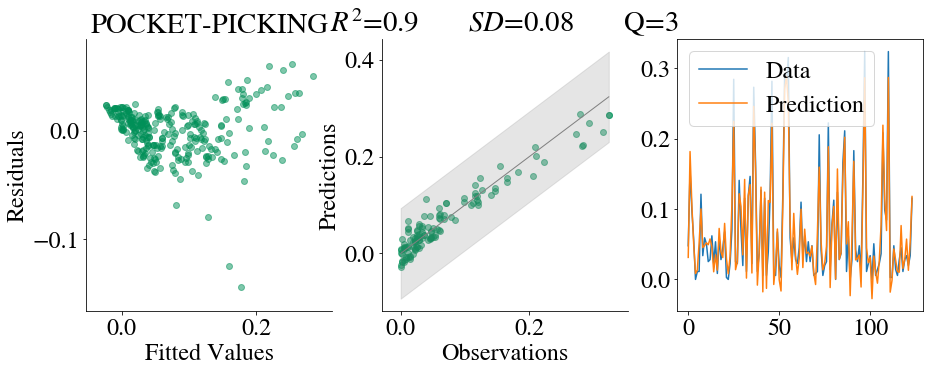

Ho null hypothesis
chi2 =9.587433639301638
chi2Table =16.92
Equation coefficients
const                    -0.159911
betweenness_centrality   -0.029681
boardings                 0.035494
alightings                0.004422
L                         0.755361
C                         0.095261
$500 AND UNDER            0.385690
ATTEMPT THEFT             0.060378
PURSE-SNATCHING           0.006192
dtype: float64
                             vif
betweenness_centrality  1.434709
boardings               3.319625
alightings              3.201003
L                       3.131867
C                       2.293081
$500 AND UNDER          9.037004
ATTEMPT THEFT           5.203818
PURSE-SNATCHING         4.107488


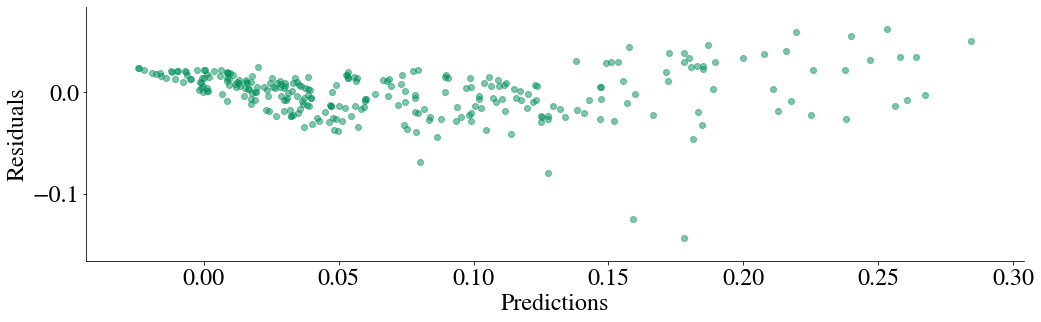

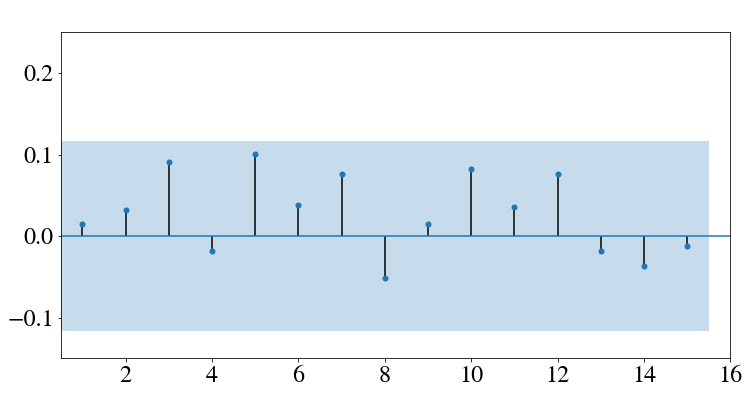

0.0005512331245541353
0.9480997814625126
POCKET-PICKING Q=3
################################################################


In [134]:
## Test model with a specific Theft 'POCKET-PICKING' and III and IV quartiles
ths = [
        '$500 AND UNDER', 'ATTEMPT THEFT','FINANCIAL ID THEFT: OVER $300',
       'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500',
       'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'
    ]

ths = [
        '$500 AND UNDER', 
        'ATTEMPT THEFT',
        'POCKET-PICKING', 
        'PURSE-SNATCHING'
    ]

for th in ['POCKET-PICKING']:
    print('################################################################') 
    print(th)

    df2 = prepare_df2(th, dbTH, df1)
    df2 = df2[df2[th] > 0]
    ix = outliers_thefts(df2, th)
    df2 = df2[ix]
    
    qs = df2[[th]].quantile([.25, .5, .75, 1]).values
    for q in [2]:
        df3 = df2[(df2[[th]] >= qs[q]).values]
        ths1 = [m for m in ths if m != th]
        d = np.sum(df3[th].values)/np.sum(df3[ths1].sum(axis=0).values)
        di = df3[th]/df3[ths1].sum(axis=1)
        L = di/d
        C = df3[th]/df3[['boardings', 'alightings']].sum(axis=1)
        dft = pd.concat([ df3[[
                            'betweenness_centrality', 
                            'boardings', 'alightings']],
                            L,
                            C,
                            df3[ths]
                        ], axis=1, sort=True)
        dft = dft.rename(columns = {0:'L', 1: 'C'})

        dft = norm_df(dft)

        train, test = sklearn.model_selection.train_test_split(dft, train_size = .7)
        
        train = train[outliers_thefts(train, th)].dropna()
        test = test[outliers_thefts(test, th)].dropna()
        
        olsres = compute_ols(train, th)
        fitted_vals = Homoscedasticity_test1(olsres, test, q, th) 
        Multicollinearity_test2(train, th)
        NoAutoCorrelation_test3(fitted_vals)
        
        from scipy.stats.stats import pearsonr
        print(np.square(np.subtract(train[th], fitted_vals)).mean())        
        print(pearsonr(train[th], fitted_vals)[0])        
        
        print(th + ' Q=' + str(q+1))    
        print('################################################################')


OLS: 0.897828 (0.065927)
OLS: -0.000486 (0.000206)
NN: -0.286074 (0.854361)
NN: -0.006040 (0.003014)
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


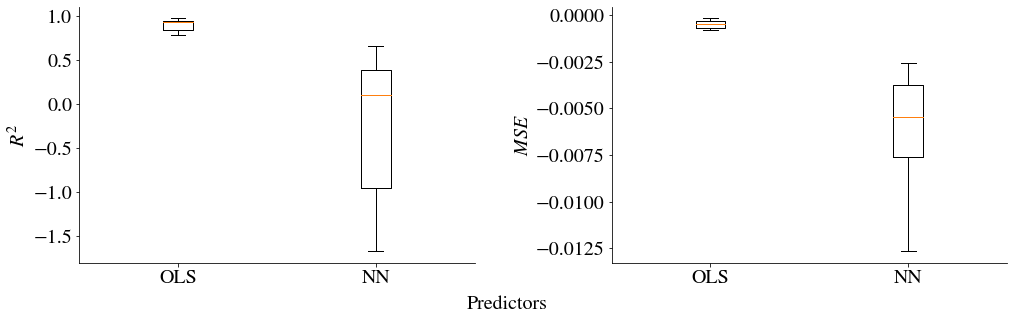

In [187]:
## Test different predictors
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

X = test.drop([th], axis=1)
Y = test[th]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
# models.append(('LR', LogisticRegression()))

models.append(('OLS', LinearRegression()))
models.append(('NN', MLPRegressor()))
# models.append(('KNN', KNeighborsClassifier()))
# # models.append(('DT', DecisionTreeClassifier()))
# # models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

from sklearn.metrics import r2_score

# evaluate each model in turn
resultsR2 = []
namesR2 = []

resultsMSE = []
namesMSE = []

scoring = ['r2', 'neg_mean_squared_error']
for name, model in models:
        
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
#     cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    cv_results = model_selection.cross_validate(model, X, Y, cv=kfold, scoring=scoring)
    
    resultsR2.append(cv_results['test_r2'])
    namesR2.append(name)
    
    resultsMSE.append(cv_results['test_neg_mean_squared_error'])
    namesMSE.append(name)    
    
    msg = "%s: %f (%f)" % (name, cv_results['test_r2'].mean(), cv_results['test_r2'].std())
    print(msg)
    msg = "%s: %f (%f)" % (name, cv_results['test_neg_mean_squared_error'].mean(), cv_results['test_neg_mean_squared_error'].std())
    print(msg)

    
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
    
# boxplot algorithm comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].boxplot(resultsR2)
ax[0].set_xticklabels(namesR2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel(r'$R^2$')


ax[1].boxplot(resultsMSE)
ax[1].set_xticklabels(namesMSE)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylabel(r'$MSE$')

fig.text(0.5, 0.05, 'Predictors', ha='center')

fig.tight_layout(pad=2.0)

plt.savefig("predictors.PNG", dpi=300)
print(model)



MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
ANN
R2 = 0.6134494797165027
MSE = 0.0024057321025752047
Correlation coef = 0.648300781324692
OLS
R2 = 0.9213139599307033
MSE = 0.0004897096826577665
Correlation coef = 0.9233891103329237


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0.04, 0.5, 'Predictions')

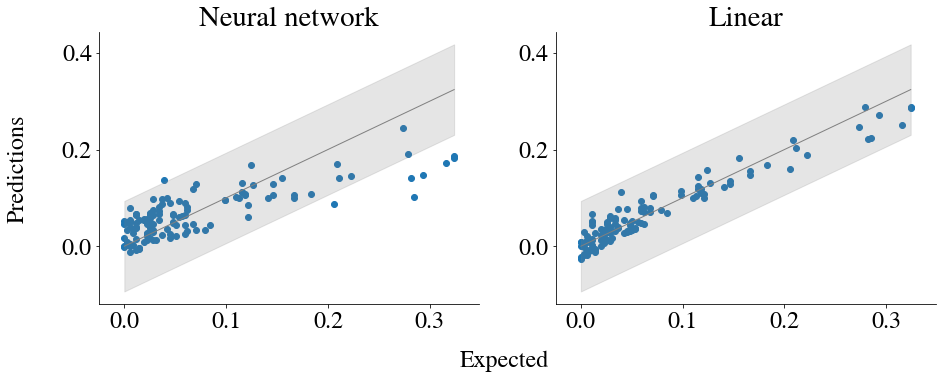

In [156]:
## Test different predictors - scatter plots
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.stats.stats import pearsonr

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

X = train.drop([th], axis=1)
Y = train[th]

# fit a CART model to the data
model = MLPRegressor()
model.fit(X, Y)
print(); print(model)

# make predictions
expected_y  = test[th]
predicted_y = model.predict(test.drop([th], axis=1))

print("ANN")
print("R2 = ", end='')
print(metrics.r2_score(expected_y, predicted_y))
print("MSE = ", end='')
print(np.square(np.subtract(expected_y, predicted_y)).mean())
print("Correlation coef = ", end='')
print(np.square(pearsonr(expected_y, predicted_y)[0]))

ax[0].scatter(y_true, predicted_y)
ax[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'gray', lw=1)
ax[0].fill_between(xplt, xplt-np.std(xplt), xplt+np.std(xplt), color='gray', alpha=0.2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# ax[0].set_ylabel('Predictions')
# ax[0].set_xlabel('Expected')
ax[0].set_title('Neural network')




fitted_vals = olsres.predict()
resids = olsres.resid
Xnew = test.drop([th], axis=1)
X_constant1 = sm.add_constant(Xnew)
y_true = test[th]
ynewpred =  olsres.predict(X_constant1)

xplt = np.linspace(y_true.min(), y_true.max(), 1000)
      
print("OLS")
print("R2 = ", end='')
print(metrics.r2_score(y_true, ynewpred))
print("MSE = ", end='')
print(np.square(np.subtract(y_true, ynewpred)).mean())
print("Correlation coef = ", end='')
print(np.square(pearsonr(y_true, ynewpred)[0]))

ax[1].scatter(y_true, ynewpred)
ax[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'gray', lw=1)
ax[1].fill_between(xplt, xplt-np.std(xplt), xplt+np.std(xplt), color='gray', alpha=0.2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].set_ylabel('Predictions')
ax[1].set_xlabel('')
ax[1].set_title('Linear')

fig.text(0.5, -0.05, 'Expected', ha='center')
fig.text(0.04, 0.5, 'Predictions', va='center', rotation='vertical')